In [1]:
from WealthIncomeMPModel_case import WealthIncomeModelClass_CaseStudy
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "black",
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "font.size": 14                 
})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from EconDLSolvers import choose_gpu
import torch, gc
import os
import numpy as np
import pandas as pd
# Hyperparameters
device = choose_gpu()
model_DL = {}
torch.cuda.empty_cache()

# 1. Initialize both models 
model_DL[r'Baseline'] = WealthIncomeModelClass_CaseStudy(
    device=device,
    load='DeepSimulate_hetero_beta.pkl'
)

model_DL[r'Experiment'] = WealthIncomeModelClass_CaseStudy(
    device=device,
    load='DeepSimulate_hetero_beta.pkl'
)


# 2. modify par manually
model_DL[r'Baseline'].par.R_shock = 0
model_DL[r'Baseline'].par.experiment = None
#model_DL[r'Baseline'].sim.N = 10_000

model_DL[r'Experiment'].par.experiment = "R1pp"
model_DL[r'Experiment'].par.R_shock = -0.01
model_DL[r'Experiment'].par.shock_periods = [33]
#model_DL[r'Experiment'].sim.N = 10_000




GPU 0: 79.19GB free
Best GPU: 0


In [2]:
def simulate_model(model):
    """ Simulate full lifecycle for one model. """
    
    par = model.par
    sim = model.sim

    # 1. Draw initial states
    initial_states = model.draw_initial_states(sim.N)
    print(f"initial_states shape: {initial_states.shape}")

    # 2. Draw shocks
    shocks = model.draw_shocks(sim.N)
    print(f"shocks shape: {shocks.shape}")

    # 3. Move shocks to same device
    device = sim.states.device
    shocks = shocks.to(device)

    # 4. Set into simulation
    sim.states[0] = initial_states
    sim.shocks = shocks

    # 5. Simulation loop
    for t in range(par.T-1):
        states_t = sim.states[t,:,:]
        shocks_t = sim.shocks[t]

        actions_t = model.eval_policy(model.policy_NN, states_t.unsqueeze(0))
        actions_t = actions_t.squeeze(0)

        outcomes_t = model.outcomes(states_t, actions_t, t0=t, t=t)
        reward_t = model.reward(states_t, actions_t, outcomes_t, t0=t)

        states_pd_t = model.state_trans_pd(states_t, actions_t, outcomes_t, t0=t)
        states_tp1 = model.state_trans(states_pd_t, shocks_t, t=t)

        sim.states[t+1] = states_tp1
        sim.outcomes[t] = outcomes_t
        sim.actions[t] = actions_t
        sim.reward[t] = reward_t
    return sim



In [2]:
def simulate_model(model):
    par = model.par
    sim = model.sim
    N   = sim.N           

    # ────────────────────────────────
    # 0) Trim every sim buffer to the new N
    # ────────────────────────────────
    # states[t] has shape (old_N, n_states) – we want (N, n_states)
    sim.states   = sim.states  [:, :N, :].contiguous()
    sim.actions  = sim.actions [:, :N, :].contiguous()
    sim.outcomes = sim.outcomes[:, :N, :].contiguous()
    sim.reward   = sim.reward  [:, :N].contiguous()
    
    if hasattr(sim, "shocks"):
        sim.shocks = sim.shocks[:, :N, :].contiguous()

    # ────────────────────────────────
    # 1) Draw initial states & shocks
    # ────────────────────────────────
    device         = sim.states.device
    initial_states = model.draw_initial_states(N).to(device)  # -> (N, 8)
    shocks         = model.draw_shocks(N).to(device)          # -> (T, N, n_shocks)

    # ────────────────────────────────
    # 2) Seed the sim with period-0
    # ────────────────────────────────
    sim.states[0] = initial_states    # now (N,8) ← (N,8)
    sim.shocks     = shocks

    # ────────────────────────────────
    # 3) Run the rest of the simulation
    # ────────────────────────────────
    for t in range(par.T-1):
        states_t   = sim.states[t]           # (N,8)
        shocks_t   = sim.shocks[t]           # (N,n_shocks)
        actions_t  = model.eval_policy(
                          model.policy_NN,
                          states_t.unsqueeze(0)
                     ).squeeze(0)           # (N,n_actions)
        outcomes_t = model.outcomes(states_t, actions_t, t0=t, t=t)
        reward_t   = model.reward(states_t, actions_t, outcomes_t, t0=t)
        pd_t       = model.state_trans_pd(states_t, actions_t, outcomes_t, t0=t)
        next_s     = model.state_trans(pd_t, shocks_t, t=t)

        sim.states [t+1] = next_s
        sim.outcomes[t]  = outcomes_t
        sim.actions [t]  = actions_t
        sim.reward  [t]  = reward_t

    return sim


In [3]:
# Loop over all models in model_DL
for model_name, model in model_DL.items():
    print(f"Simulating {model_name}...")
    simulate_model(model)

Simulating Baseline...
initial_states shape: torch.Size([100000, 8])
shocks shape: torch.Size([75, 100000, 4])
Simulating Experiment...
initial_states shape: torch.Size([100000, 8])
shocks shape: torch.Size([75, 100000, 4])


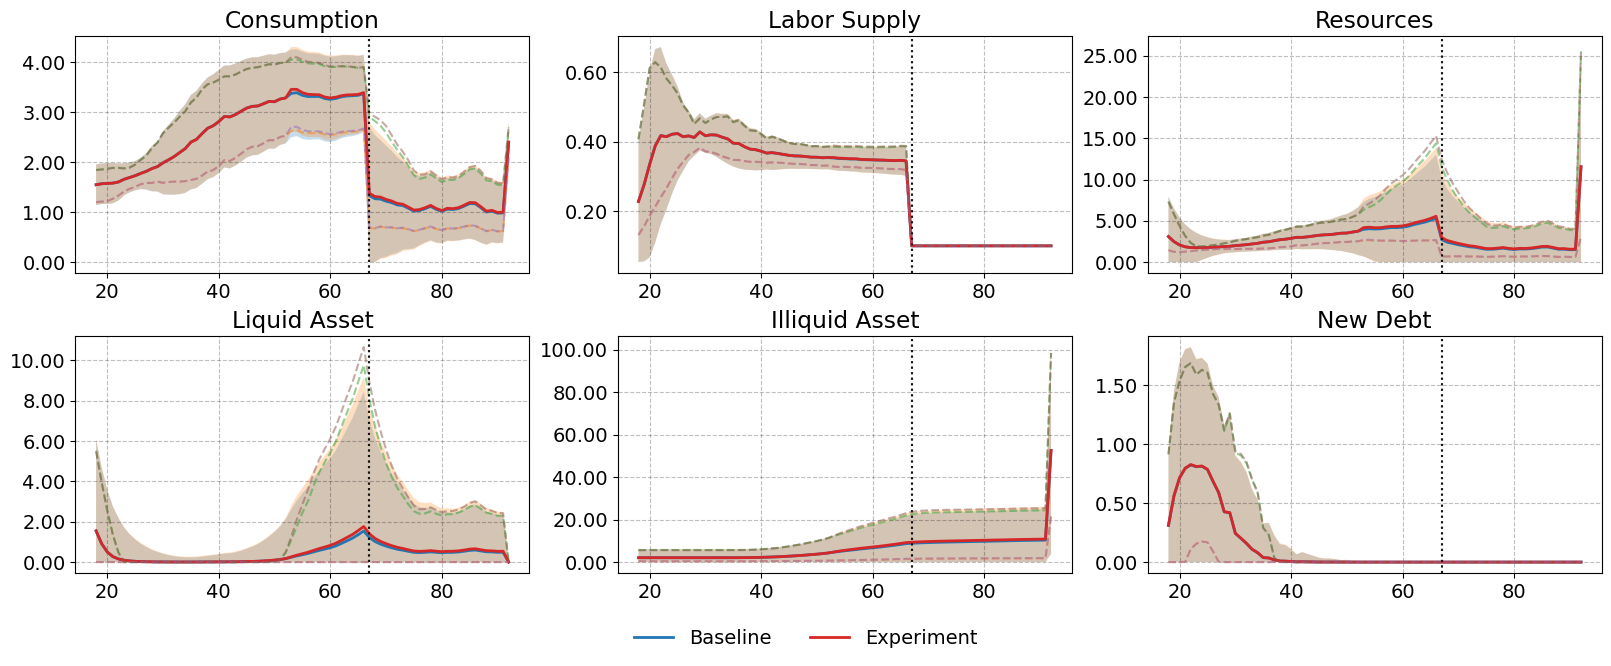

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --------------------------------------------------
# 1.  CREATE CANVAS   (2 rows × 3 columns = 6 slots)
# --------------------------------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(16, 6),
    constrained_layout=True
)
axes = axes.flatten()

titles = [
    'Consumption',     # 0
    'Labor Supply',    # 1
    'Resources',       # 2  <-- fixed spelling
    'Liquid Asset',    # 3
    'Illiquid Asset',  # 4
    'New Debt'         # 5
]

var_to_ax = {i: i for i in range(6)}

# --------------------------------------------------
# 2.  PLOT THE SERIES
# --------------------------------------------------
for model_key, model_obj in model_DL.items():
    outcomes = model_obj.sim.outcomes.detach().cpu().numpy()
    age = np.arange(outcomes.shape[0]) + 18

    for var_idx, ax_idx in var_to_ax.items():
        data = outcomes[:, :, var_idx]
        mean = data.mean(axis=1)
        std  = data.std(axis=1)
        p5, p95 = np.percentile(data, [5, 95], axis=1)

        ax = axes[ax_idx]
        ax.plot(age, mean, lw=2, label=model_key)
        lower = np.maximum(mean - 2*std, 0)
        upper = mean + 2*std
        ax.fill_between(age, lower, upper, alpha=0.25)       # <-- use age here
        ax.plot(age, p5,  ls='--', alpha=0.5)
        ax.plot(age, p95, ls='--', alpha=0.5)
        ax.axvline(67, ls=':', color='k', alpha=0.7)

# --------------------------------------------------
# 3.  AESTHETICS
# --------------------------------------------------
for idx, title in enumerate(titles):
    axes[idx].set_title(title)

for ax in axes:
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# --------------------------------------------------
# 4.  SINGLE, DEDUPLICATED LEGEND
# --------------------------------------------------
#handles, labels = axes[0].get_legend_handles_labels()
#uniq = {lab: h for h, lab in zip(handles, labels)}

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, -0.1),
           ncol=len(labels), frameon=False)

# 5) save, using bbox_inches='tight' to grab the legend too
fig.savefig(
    "Outcomes_Baseline_Experiment_SOFT_AGE51.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()




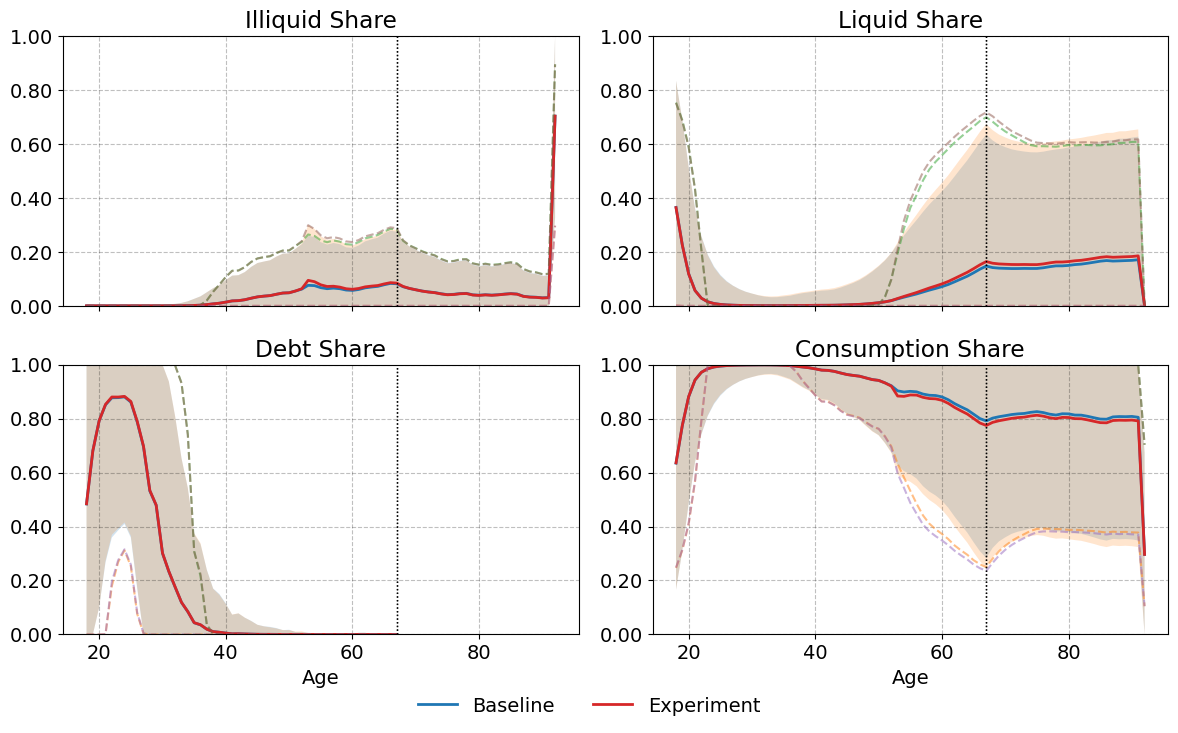

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- 1) Define shares to plot ---
# 1: illiquid, 2: liquid, 3: debt; plus computed consumption
plot_order = [
    (1, 'Illiquid Share'),
    (2, 'Liquid Share'),
    (3, 'Debt Share'),
    ('cons', 'Consumption Share')
]

age_start = 18
ret_age   = 67

# --- 2) Prepare 2×2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# --- 3) Loop over models and panels ---
for model_key in model_DL:
    actions = model_DL[model_key].sim.actions.detach().cpu().numpy()
    T       = actions.shape[0]
    x       = np.arange(age_start, age_start + T)

    # compute consumption share
    ill  = actions[:, :, 1]
    liq  = actions[:, :, 2]
    cons = (1 - ill) * (1 - liq)

    for ax, (v_idx, title) in zip(axes, plot_order):
        if v_idx == 'cons':
            data = cons
            xplt = x
        else:
            data = actions[:, :, v_idx]
            if title == 'Debt Share':
                mask = x <= ret_age
                xplt = x[mask]
                data = data[mask, :]
            else:
                xplt = x

        mean    = data.mean(1)
        std     = data.std(1)
        p5, p95 = np.percentile(data, [5, 95], axis=1)

        lower = np.maximum(mean - 2*std, 0)
        upper = np.minimum(mean + 2*std, 1)
        p5    = np.maximum(p5, 0)
        p95   = np.minimum(p95, 1)

        ax.plot(xplt, mean, lw=2, label=model_key)
        ax.fill_between(xplt, lower, upper, alpha=0.2)
        ax.plot(xplt, p5 , ls='--', alpha=0.5)
        ax.plot(xplt, p95, ls='--', alpha=0.5)

        # retirement line on all panels
        ax.axvline(ret_age, color='black', ls=':', lw=1)

        ax.set_title(title)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        ax.set_ylim(0,1)

# --- 4) Configure x-axis only on bottom row ---
for idx, ax in enumerate(axes):
    if idx >= 2:
        ax.set_xlabel("Age")
    else:
        ax.tick_params(labelbottom=False)

# --- 5) Legend & layout ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, 0.02),
           ncol=len(labels), frameon=False)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])

fig.savefig('Actions_Baseline_Experiment_SOFT_AGE51.png', dpi=300)
#fig.savefig('Actions_Baseline_Experiment.png', dpi=300)
plt.show()


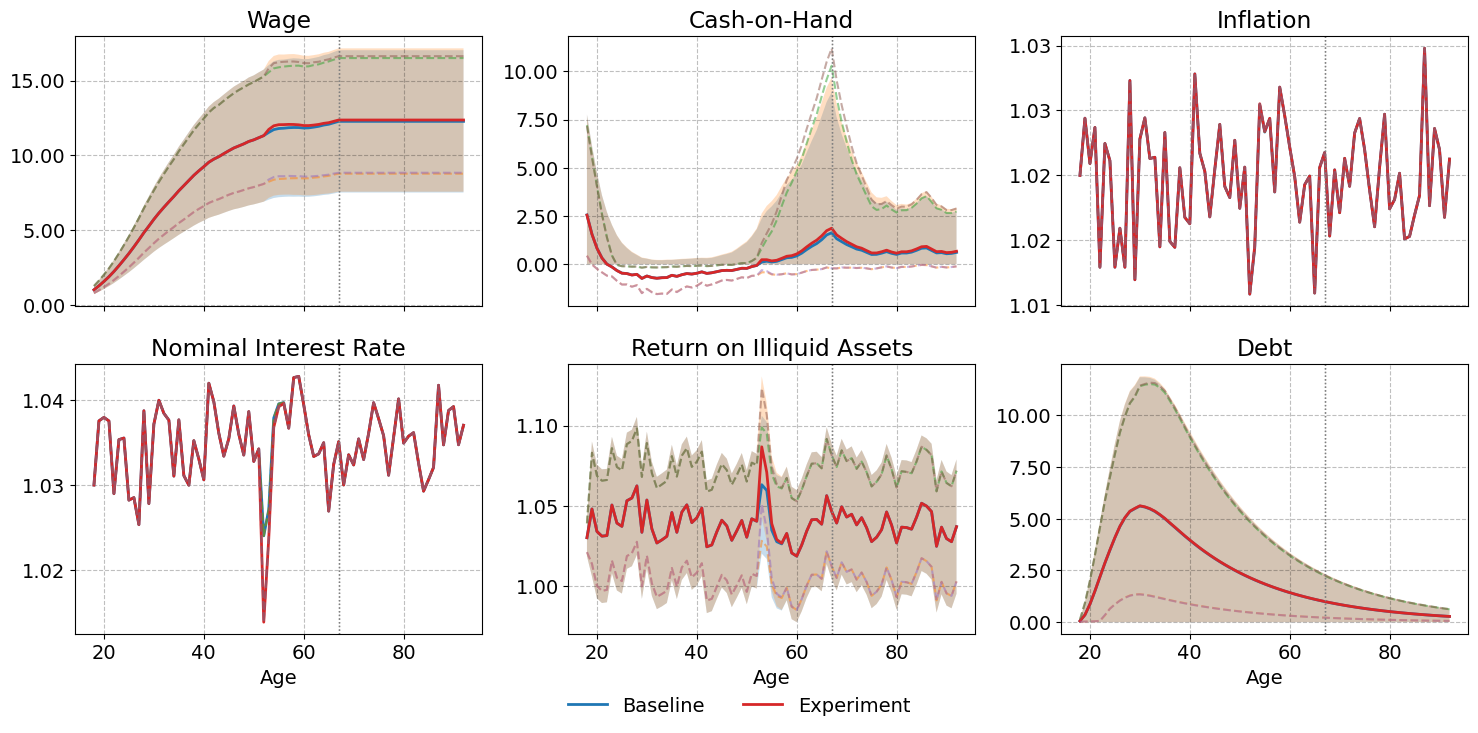

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

# --- 1) Which state‐indices to show (no Illiquid Assets idx=0) ---
core_vars = {
    1: 'Wage',
    2: 'Cash-on-Hand',
    3: 'Inflation',
    4: 'Nominal Interest Rate',
    5: 'Return on Illiquid Assets',
    6: 'Debt'
}

age_start = 18
n_vars    = len(core_vars)
n_cols    = 3
n_rows    = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5*n_cols, 4*n_rows),
                         sharex=True)
axes = axes.flatten()

for model_key in model_DL:
    states = model_DL[model_key].sim.states.detach().cpu().numpy()
    T      = states.shape[0]
    x      = np.arange(age_start, age_start + T)

    for pos, (var_idx, title) in enumerate(core_vars.items()):
        ax   = axes[pos]
        data = states[:, :, var_idx]     # (T, n_sims)

        mean    = data.mean(1)
        std     = data.std(1)
        p5, p95 = np.percentile(data, [5,95], axis=1)

        ax.plot(x, mean, lw=2, label=model_key)
        lower = np.maximum(mean - 2*std, 0)
        upper = mean+2*std
        ax.fill_between(x, lower, upper, alpha=0.25)
        ax.plot(x, p5 , ls='--', alpha=0.5)
        ax.plot(x, p95, ls='--', alpha=0.5)
        ax.axvline(age_start + 49, color='gray', ls=':', lw=1)
        ax.set_title(title)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# hide unused panels
for extra_ax in axes[n_vars:]:
    extra_ax.axis('off')

# show x‐ticklabels only on bottom row
for pos, ax in enumerate(axes[:n_vars]):
    if pos // n_cols == n_rows - 1:
        ax.set_xlabel("Age")
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, 0.02),
           ncol=len(labels), frameon=False)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig("States_Baseline_Experiment_SOFT_AGE51.png", dpi=300, bbox_inches='tight')
#fig.savefig("States_DeepVPD.png", dpi=300)
#fig.savefig("States_DeepSimulate.png", dpi=300)
plt.show()




In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch


# --- 2) Net-wealth helper ---
def compute_net_wealth(states, outcomes):
    ill  = outcomes[..., 4]
    liq  = outcomes[..., 3]
    debt = states[..., 6]
    nd   = outcomes[..., 5]
    return ill + liq - debt - nd


# --- 3) Age-bin definitions (unchanged) ---
age_start  = 18
age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

torch.manual_seed(1337)
N      = model_DL['Baseline'].sim.N
device = model_DL['Baseline'].sim.states.device
raw    = model_DL['Baseline'].draw_shocks(N).to(device)
model_DL['Baseline'].sim.shocks   = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()


# --- 5) Run 3-shock experiment for each age bin, collect pct‐changes ---
percent_changes = []

for (a_lo, a_hi) in age_bins:
    t_lo  = a_lo - age_start
    t_hi  = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    #t_mid = (t_lo + t_hi) // 2
    shock_dates = [t_lo] #, t_mid, t_hi]

    # Baseline: reuse pre-drawn shocks, no policy shocks
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []
    sb = simulate_model(mb)
    sb_s, sb_o = sb.states.detach().cpu().numpy(), sb.outcomes.detach().cpu().numpy()
    nw_b = compute_net_wealth(sb_s, sb_o)

    # Experiment: same shocks + policy shocks at start, mid, end
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = shock_dates
    se = simulate_model(me)
    se_s, se_o = se.states.detach().cpu().numpy(), se.outcomes.detach().cpu().numpy()
    nw_e = compute_net_wealth(se_s, se_o)

    # percent‐change (exp vs base) over t_lo onward to t_hi
    pct = (nw_e[t_lo:t_hi, :] - nw_b[t_lo:t_hi, :]) / nw_b[t_lo:t_hi, :] * 100
    percent_changes.append(pct.ravel())


In [3]:
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1) Helper: net-wealth from states/outcomes tensors
# ---------------------------------------------------------------------
def compute_net_wealth(states, outcomes):
    """Return ndarray [T, N] of liquid+illiquid-assets minus debt."""
    ill  = outcomes[..., 4]
    liq  = outcomes[..., 3]
    debt = states[..., 6]
    nd   = outcomes[..., 5]
    return ill + liq - debt - nd


# ---------------------------------------------------------------------
# 2) Age-bin definitions 
# ---------------------------------------------------------------------
age_start  = 18
#age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
#age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

age_bins   = [(18, 28), (29, 39), (40, 50), (51, 61), (62,72),(73,83)]
age_labels = ["18–28", "29–39", "40–50", "51–61", "62–72", "73-83"]

# ---------------------------------------------------------------------
# 3) Fix random shocks so baseline/experiment are comparable
# ---------------------------------------------------------------------
torch.manual_seed(1337)
N      = model_DL['Baseline'].sim.N
device = model_DL['Baseline'].sim.states.device
raw    = model_DL['Baseline'].draw_shocks(N).to(device)
model_DL['Baseline'].sim.shocks   = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()

# ---------------------------------------------------------------------
# 4) Simulate: for each age-bin run baseline vs. experiment
#              and collect %-changes (time × N) into a list.
# ---------------------------------------------------------------------
pct_changes = []                       # ragged list: each entry shape (T_bin, N)

for (a_lo, a_hi) in age_bins:
    t_lo  = a_lo - age_start
    t_hi  = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    shock_dates = [t_lo]              # shock hits at the start of the bin

    # ---------- baseline ----------
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []         # no policy shock
    sb   = simulate_model(mb)
    nw_b = compute_net_wealth(sb.states.detach().cpu().numpy(),
                              sb.outcomes.detach().cpu().numpy())

    # ---------- experiment ----------
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = shock_dates
    se   = simulate_model(me)
    nw_e = compute_net_wealth(se.states.detach().cpu().numpy(),
                              se.outcomes.detach().cpu().numpy())

    # ---------- %-change ----------
    pct = (nw_e[t_lo:t_hi, :] - nw_b[t_lo:t_hi, :]) / nw_b[t_lo:t_hi, :] * 100
    pct_changes.append(pct)           # shape (T_bin, N) — keep time axis!

# ---------------------------------------------------------------------
# 5) Pad to uniform cube (bins × T_max × N) with NaNs
# ---------------------------------------------------------------------
n_bins   = len(age_bins)
T_max    = max(p.shape[0] for p in pct_changes)   # longest horizon
N_agents = pct_changes[0].shape[1]
#
pct_cube = np.full((n_bins, T_max, N_agents), np.nan, dtype=float)
for i, pct in enumerate(pct_changes):
    pct_cube[i, :pct.shape[0], :] = pct           # left-align



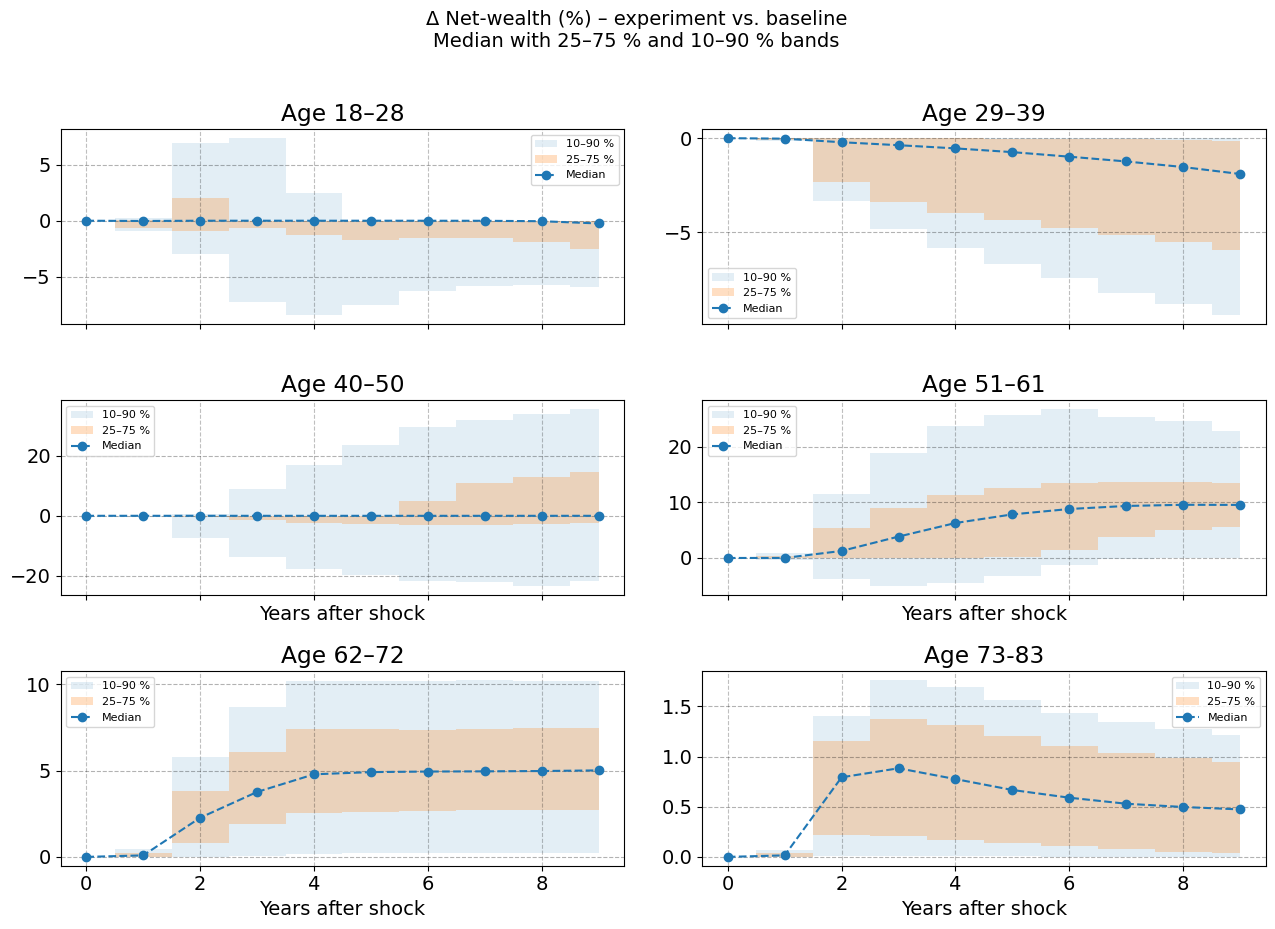

In [5]:
# -----------------------------------------------------------------
# 6) Fast + clean: median line with shaded 10–90 and 25–75 bands
# -----------------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True)
axes = axes.ravel()

for idx in range(n_bins):

    # Pre-allocate summary arrays (length = valid years in this bin)
    med, p10, p25, p75, p90, years = [], [], [], [], [], []

    for t in range(T_max):
        vec = pct_cube[idx, t, :]
        vec = vec[~np.isnan(vec)]
        if vec.size:
            years.append(t)
            p10.append(np.percentile(vec, 10))
            p25.append(np.percentile(vec, 25))
            med.append(np.median(vec))
            p75.append(np.percentile(vec, 75))
            p90.append(np.percentile(vec, 90))

    ax = axes[idx]

    # 10–90 band  (lightest)
    ax.fill_between(years, p10, p90, alpha=0.12, step="mid",
                    label="10–90 %")

    # 25–75 band  (darker)
    ax.fill_between(years, p25, p75, alpha=0.25, step="mid",
                    label="25–75 %")

    # Median
    ax.plot(years, med, marker="o", linestyle="--", label="Median")

    ax.set_title(f"Age {age_labels[idx]}")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(fontsize=8)

# Shared x-label
for ax in axes[2:]:
    ax.set_xlabel("Years after shock")

fig.suptitle("Δ Net-wealth (%) – experiment vs. baseline\n"
             "Median with 25–75 % and 10–90 % bands",
             fontsize=14, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


ValueError: X must have 2 or fewer dimensions

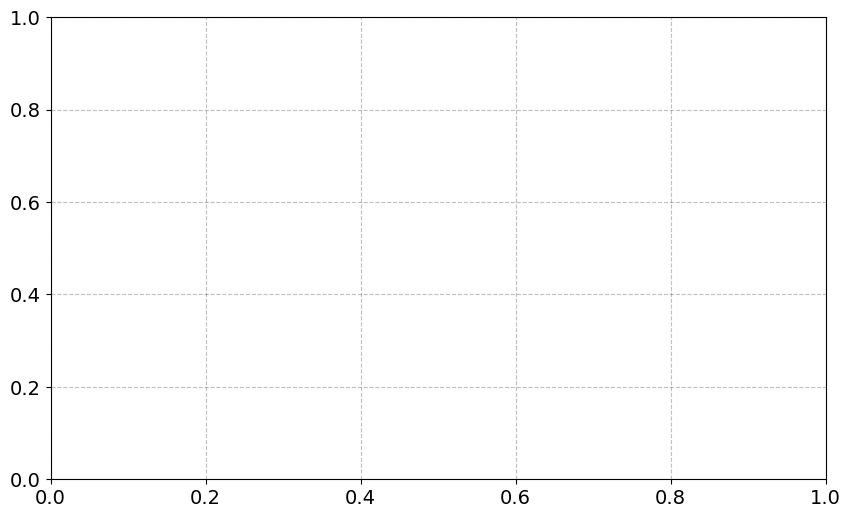

In [5]:
percent_changes = pct_changes
# --- 6) Plot distribution of 3-shock impacts by age bin ---
fig, ax = plt.subplots(figsize=(10, 6))
xpos = np.arange(len(age_labels))

# 6a) draw boxplot with 1.5×IQR whiskers
bp = ax.boxplot(
    percent_changes,
    positions=xpos,
    widths=0.6,
    notch=True,
    showfliers=False,
    whis=1.5,
    patch_artist=True,
    medianprops=dict(color="#2f4f4f", linewidth=1.5),
    whiskerprops=dict(color="#555555", linewidth=1),
    capprops=dict(color="#555555", linewidth=1),
)

# 6b) color boxes
for box in bp["boxes"]:
    box.set_facecolor("#8dd3c7")
    box.set_alpha(0.7)

# 6c) hide the first cohort’s box elements
#i0 = 0
# box rectangle
#bp["boxes"][i0].set_visible(False)
# the first two whiskers and caps
#bp["whiskers"][2*i0  ].set_visible(False)
#bp["whiskers"][2*i0+1].set_visible(False)
#bp["caps"][2*i0      ].set_visible(False)
#bp["caps"][2*i0+1    ].set_visible(False)
# the first median line
#bp["medians"][i0].set_visible(False)

# 6d) zero line
ax.axhline(0, linestyle="--", color="gray", linewidth=1)

# 6e) cohort medians & means for all bins
cohort_medians = np.array([np.nanmedian(pc) for pc in percent_changes])
cohort_means = []
for i, pc in enumerate(percent_changes):
    lo = bp["caps"][2*i].get_ydata()[0]
    hi = bp["caps"][2*i+1].get_ydata()[0]
    in_range = pc[(pc >= lo) & (pc <= hi)]
    cohort_means.append(np.nanmean(in_range))
cohort_means = np.array(cohort_means)

# 6f) plot medians & means for **all** cohorts
ax.scatter(
    xpos, cohort_medians,
    marker='D', s=60,
    facecolors='#2f4f4f', edgecolors='white',
    linewidths=1.2, zorder=4,
    label="Cohort Median"
)
ax.scatter(
    xpos, cohort_means,
    marker='o', s=50,
    facecolors='white', edgecolors='#e6550d',
    linewidths=1.5, zorder=5,
    label="Cohort Mean"
)

# 6g) annotate:
for i in range(len(age_labels)):
    x_off = 0.35 if i < len(age_labels)-1 else 0.3
    med       = cohort_medians[i]
    mean_val  = cohort_means[i]
    # caps for annotation
    lo = bp["caps"][2*i].get_ydata()[0]
    hi = bp["caps"][2*i+1].get_ydata()[0]

    if i == 100:
        # only label median & mean (no min/max)
        ax.text(
            xpos[i]+x_off, med ,
            f"{med:.1f}%",
            ha="left", va="center",
            fontsize=9, fontweight="bold", color="#2f4f4f"
        )
        ax.text(
            xpos[i]+x_off, mean_val +1 ,
            f"{mean_val:.1f}%",
            ha="left", va="center",
            fontsize=8, fontweight="bold", color="#e6550d"
        )
    else:
        # annotate min, max, median, mean as before
        ax.text(
            xpos[i]+x_off-0.5, hi + 1.75,
            f"max {hi:.1f}%",
            ha="left", va="bottom",
            fontsize=8, fontweight="bold", color="#333333"
        )
        ax.text(
            xpos[i]+x_off-0.5, lo - 1,
            f"min {lo:.1f}%",
            ha="left", va="top",
            fontsize=8, fontweight="bold", color="#333333"
        )
        ax.text(
            xpos[i]+x_off, med ,
            f"{med:.1f}%",
            ha="left", va="center",
            fontsize=9, fontweight="bold", color="#2f4f4f"
        )
        ax.text(
            xpos[i]+x_off, mean_val +2 ,
            f"{mean_val:.1f}%",
            ha="left", va="center",
            fontsize=8, fontweight="bold", color="#e6550d"
        )

# final formatting
ax.set_xticks(xpos)
ax.set_xticklabels(age_labels, rotation=45, ha="right")
ax.set_ylabel("Percent Change in Net-Wealth")
ax.grid(axis='y', linestyle=':', linewidth=0.8, alpha=0.7)
ax.legend(frameon=False, loc='upper right')
ax.set_ylim([-20, 35])

plt.tight_layout()
#plt.savefig("mp_soft_net_wealth_boxplot.png", dpi=300)
plt.show()


In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch


# 2) Income, wealth helpers
def compute_work_income(states, outcomes, kappa):
    wages = states[..., 1]
    hours = outcomes[..., 1]
    return kappa[:, None] * wages * hours

def compute_invest_income(states, outcomes):
    rtn_ill  = states[..., 5]
    rtn_liq  = states[..., 4]
    ill_new  = outcomes[..., 4]
    liq_new  = outcomes[..., 3]
    return (ill_new ) * (rtn_ill-1) + liq_new * (rtn_liq-1)

def compute_net_wealth(states, outcomes):
    """Return ndarray [T, N] of liquid+illiquid-assets minus debt."""
    ill  = outcomes[..., 4]
    liq  = outcomes[..., 3]
    debt = states[..., 6]
    nd   = outcomes[..., 5]
    return ill + liq - debt - nd


# 3) Age bins
age_start  = 18
#age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
#age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

age_bins   = [(18, 28), (29, 39), (40, 50), (51, 61), (62,72),(73,83)]
age_labels = ["18–28", "29–39", "40–50", "51–61", "62–72", "73-83"]

# 4) Pre-draw & share idio shocks
torch.manual_seed(1337)
N      = model_DL['Baseline'].sim.N
device = model_DL['Baseline'].sim.states.device
raw    = model_DL['Baseline'].draw_shocks(N).to(device)
model_DL['Baseline'].sim.shocks   = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()

# 5) Collect %Δ for work & investment
pct_work   = []
pct_invest = []

for (a_lo, a_hi) in age_bins:
    t_lo  = a_lo - age_start
    t_hi  = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)

    # baseline
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []
    sb = simulate_model(mb)
    Sb, Ob = sb.states.detach().cpu().numpy(), sb.outcomes.detach().cpu().numpy()
    kb      = mb.par.kappa.detach().cpu().numpy()
    WI_b    = compute_work_income(Sb, Ob, kb)
    II_b    = compute_invest_income(Sb, Ob)

    # experiment
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = [t_lo]
    se = simulate_model(me)
    Se, Oe = se.states.detach().cpu().numpy(), se.outcomes.detach().cpu().numpy()
    ke      = me.par.kappa.detach().cpu().numpy()
    WI_e    = compute_work_income(Se, Oe, ke)
    II_e    = compute_invest_income(Se, Oe)

    # percent changes (mask zero baseline)
    base_w = WI_b[t_lo:t_hi].ravel()
    exp_w  = WI_e[t_lo:t_hi].ravel()
    mask_w = base_w != 0
    pct_work.append((exp_w[mask_w] - base_w[mask_w]) / base_w[mask_w] * 100)

    base_i = II_b[t_lo:t_hi].ravel()
    exp_i  = II_e[t_lo:t_hi].ravel()
    mask_i = base_i != 0
    pct_invest.append((exp_i[mask_i] - base_i[mask_i]) / base_i[mask_i] * 100)



In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch


# 2) Income helpers
def compute_work_income(states, outcomes, kappa):
    wages = states[..., 1]
    hours = outcomes[..., 1]
    return kappa[:, None] * wages * hours

def compute_invest_income(states, outcomes):
    rtn_ill  = states[..., 5]
    rtn_liq  = states[..., 4]
    ill_new  = outcomes[..., 4]
    liq_new  = outcomes[..., 3]
    return (ill_new ) * (rtn_ill-1) + liq_new * (rtn_liq-1)

def compute_net_wealth(states, outcomes):
    """Return ndarray [T, N] of liquid+illiquid-assets minus debt."""
    ill  = outcomes[..., 4]
    liq  = outcomes[..., 3]
    debt = states[..., 6]
    nd   = outcomes[..., 5]
    return ill + liq - debt - nd

# 3) Age bins
age_start  = 18
#age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
#age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

age_bins   = [(18, 28), (29, 39), (40, 50), (51, 61), (62,72),(73,83)]
age_labels = ["18–28", "29–39", "40–50", "51–61", "62–72", "73-83"]

# 4) Pre-draw & share idio shocks
torch.manual_seed(1337)
N      = model_DL['Baseline'].sim.N
device = model_DL['Baseline'].sim.states.device
raw    = model_DL['Baseline'].draw_shocks(N).to(device)
model_DL['Baseline'].sim.shocks   = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()

# 5) Collect %Δ for work & investment
pct_work   = []
pct_invest = []
pct_total = []
pct_wealth = []
pct_money = []

for (a_lo, a_hi) in age_bins:
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)

    # ---------- baseline ----------
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []
    sb = simulate_model(mb)
    Sb, Ob = sb.states.detach().cpu().numpy(), sb.outcomes.detach().cpu().numpy()
    kb     = mb.par.kappa.detach().cpu().numpy()
    WI_b   = compute_work_income(Sb, Ob, kb)
    II_b   = compute_invest_income(Sb, Ob)
    nw_b   = compute_net_wealth(Sb, Ob)

    # ---------- experiment ----------
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = [t_lo]
    se = simulate_model(me)
    Se, Oe = se.states.detach().cpu().numpy(), se.outcomes.detach().cpu().numpy()
    ke     = me.par.kappa.detach().cpu().numpy()
    WI_e   = compute_work_income(Se, Oe, ke)
    II_e   = compute_invest_income(Se, Oe)
    nw_e   = compute_net_wealth(Se, Oe)

    # %-change slices (time × N); keep time axis
    with np.errstate(divide="ignore", invalid="ignore"):
        pct_w = (WI_e[t_lo:t_hi] - WI_b[t_lo:t_hi]) / WI_b[t_lo:t_hi] 
        pct_i = (II_e[t_lo:t_hi] - II_b[t_lo:t_hi]) / II_b[t_lo:t_hi] 
        pct_tot = ((WI_e[t_lo:t_hi] + II_e[t_lo:t_hi]) - (WI_b[t_lo:t_hi] + II_b[t_lo:t_hi]))/( WI_b[t_lo:t_hi] + II_b[t_lo:t_hi]) 
        pct_wlth = (nw_e[t_lo:t_hi] - nw_b[t_lo:t_hi]) / nw_b[t_lo:t_hi] 
        pct_m = (Se[t_lo:t_hi, :, 2] - Sb[t_lo:t_hi, :, 2]) / Sb[t_lo:t_hi, :, 2]

    pct_work.append(pct_w*100)
    pct_invest.append(pct_i*100)
    pct_total.append(pct_tot*100)
    pct_wealth.append(pct_wlth*100)
    pct_money.append(pct_m*100)


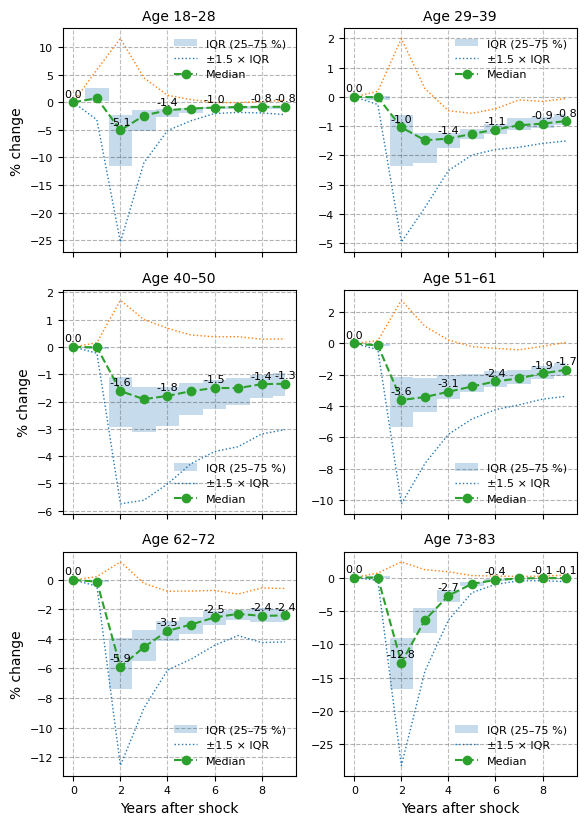

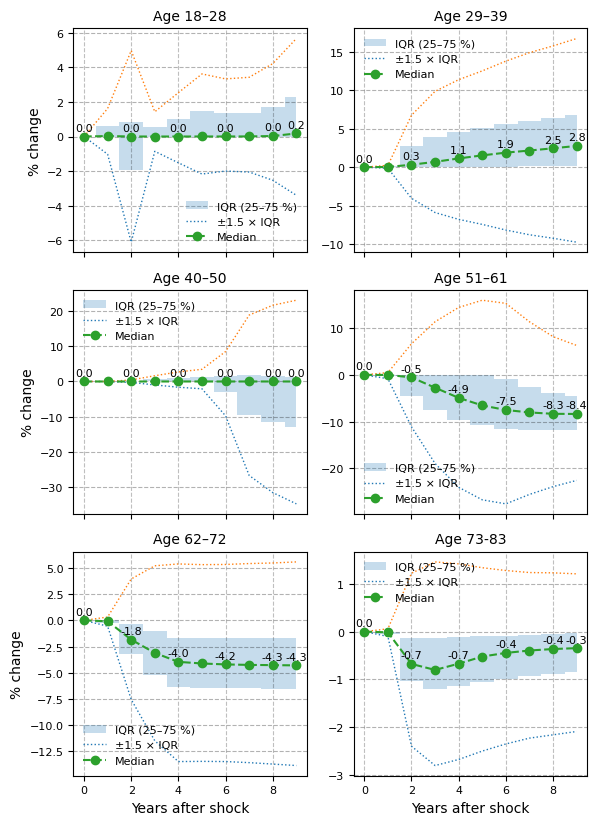

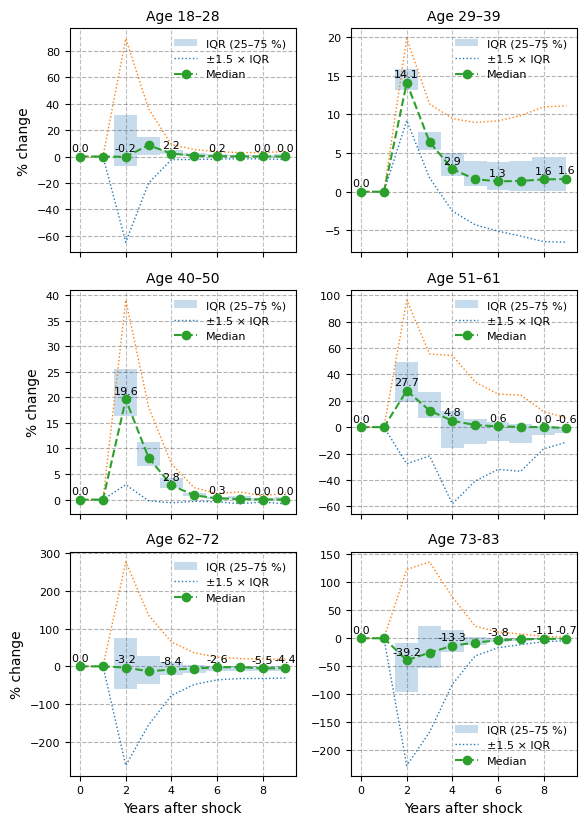

In [4]:
# ---------------------------------------------------------------
# 0) Imports  (num-py, matplotlib already loaded earlier)
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1) Padding helper  [bins, T_max, N]  with NaN
# ---------------------------------------------------------------
def to_cube(ragged):
    n_bins = len(ragged)
    T_max  = max(arr.shape[0] for arr in ragged)
    N      = ragged[0].shape[1]
    cube   = np.full((n_bins, T_max, N), np.nan)
    for i, arr in enumerate(ragged):
        cube[i, :arr.shape[0]] = arr
    return cube

# assume pct_work … pct_money already exist from simulations
cube_work   = to_cube(pct_work)
cube_invest = to_cube(pct_invest)
cube_total  = to_cube(pct_total)
cube_wealth = to_cube(pct_wealth)
cube_money  = to_cube(pct_money)

T_max  = cube_work.shape[1]
n_bins = len(age_bins)

# ---------------------------------------------------------------
# 2) Figure-size helper for full-width LaTeX placement
# ---------------------------------------------------------------
TEXTWIDTH_PT = 430           # ≈ 5.96 in for standard article.cls
IN_PER_PT    = 1 / 72.27
FIG_W        = TEXTWIDTH_PT * IN_PER_PT     # width  = \textwidth
FIG_H        = FIG_W * 1.4                 # aspect 1.4 fits 3×2 grid

# ---------------------------------------------------------------
# 3) Plot-helper: IQR ribbon, median line, y-label only left col
# ---------------------------------------------------------------
def plot_cube_IQR(cube, file_stem,
                  label_step=2, fmt="{:.1f}", ylab="% change"):
    plt.rcParams.update({                # fonts tuned for scaling via LaTeX
        "font.size":        9,
        "axes.titlesize":  10,
        "axes.labelsize":  10,
        "legend.fontsize":  8,
        "xtick.labelsize":  8,
        "ytick.labelsize":  8,
    })

    fig, axes = plt.subplots(3, 2,
                             figsize=(FIG_W, FIG_H),
                             sharex=True)
    axes = axes.ravel()

    for idx in range(n_bins):
        yrs, med, p25, p75, w_lo, w_hi = [], [], [], [], [], []
        for t in range(T_max):
            vec = cube[idx, t]
            vec = vec[~np.isnan(vec)]
            if vec.size:
                yrs.append(t)
                p25_t, p75_t = np.percentile(vec, [25, 75])
                iqr = p75_t - p25_t
                p25.append(p25_t); p75.append(p75_t)
                med.append(m := np.median(vec))
                w_lo.append(p25_t - 1.5 * iqr)
                w_hi.append(p75_t + 1.5 * iqr)

        ax = axes[idx]
        ax.fill_between(yrs, p25, p75, alpha=.25, step="mid",
                        label="IQR (25–75 %)")
        ax.plot(yrs, w_lo, ":", linewidth=1, label="±1.5 × IQR")
        ax.plot(yrs, w_hi, ":", linewidth=1)
        ax.plot(yrs, med, marker="o", linestyle="--", label="Median")

        # annotate medians
        for y, m in zip(yrs, med):
            if (y % label_step == 0) or (y == yrs[-1]):
                ax.annotate(fmt.format(m), (y, m),
                            xytext=(0,4), textcoords="offset points",
                            ha="center", fontsize=8)

        ax.set_title(f"Age {age_labels[idx]}")
        ax.grid(True, axis="y", alpha=.3)
        ax.legend(frameon=False)

        if idx % 2 == 0:                 # left column
            ax.set_ylabel(ylab)

    for ax in axes[4:]:
        ax.set_xlabel("Years after shock")

    plt.tight_layout()
    #plt.savefig(f"{file_stem}.pdf", bbox_inches="tight")   # vector graphic
    #plt.savefig(f"{file_stem}.png", dpi=300, bbox_inches="tight")  # fallback PNG
    plt.show()

# ---------------------------------------------------------------
# 4) Produce & save full-width figures
# ---------------------------------------------------------------
plot_cube_IQR(cube_total,  "total_income_change")
plot_cube_IQR(cube_wealth, "wealth_change")
plot_cube_IQR(cube_money,  "money_change")


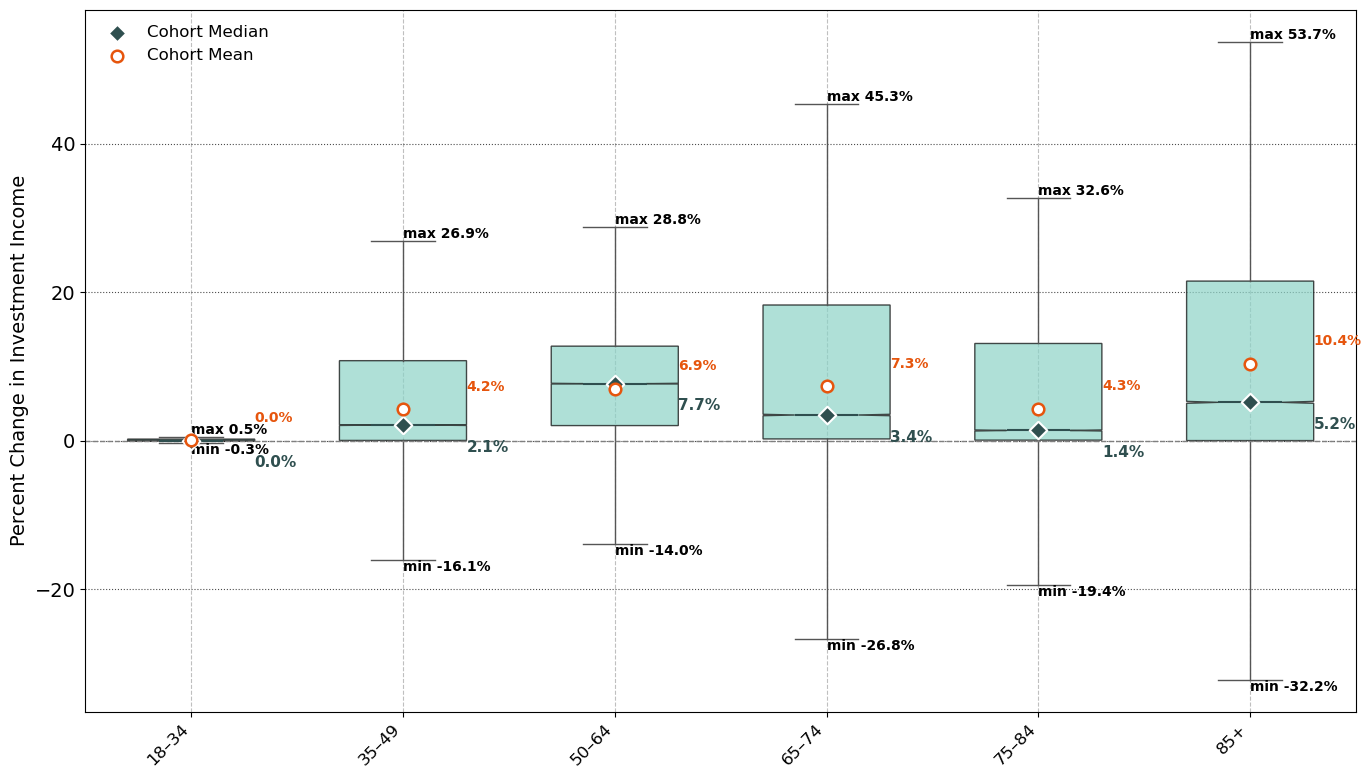

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# assume pct_invest and age_labels are already defined
# pct_invest: list of 6 arrays, one per age bin
# age_labels: ["18–34","35–49","50–64","65–74","75–84","85+"]

# 1) set up a bigger figure
fig, ax = plt.subplots(figsize=(14, 8))

xpos = np.arange(len(age_labels))

# 2) Draw the boxplot
bp = ax.boxplot(
    pct_invest,
    positions=xpos,
    widths=0.6,
    notch=True,
    showfliers=False,
    whis=1.5,
    patch_artist=True,
    medianprops=dict(color="#2f4f4f", linewidth=1.5),
    whiskerprops=dict(color="#555555", linewidth=1),
    capprops=dict(color="#555555", linewidth=1),
)

# 3) Color the boxes
for box in bp['boxes']:
    box.set_facecolor('#8dd3c7')
    box.set_alpha(0.7)

# 4) Zero line
ax.axhline(0, linestyle='--', color='gray', linewidth=1)

# 5) Compute medians & whisker‐restricted means
meds = np.array([np.nanmedian(arr) for arr in pct_invest])
means = []
for i, arr in enumerate(pct_invest):
    lo = bp['caps'][2*i].get_ydata()[0]
    hi = bp['caps'][2*i+1].get_ydata()[0]
    in_range = arr[(arr >= lo) & (arr <= hi)]
    means.append(np.nanmean(in_range))
means = np.array(means)

# 6) Scatter median & mean
ax.scatter(xpos, meds,
           marker='D', s=80,
           facecolors='#2f4f4f', edgecolors='white',
           linewidths=1.5, zorder=4,
           label='Cohort Median')
ax.scatter(xpos, means,
           marker='o', s=70,
           facecolors='white', edgecolors='#e6550d',
           linewidths=1.8, zorder=5,
           label='Cohort Mean')

# 7) Annotate min, max, median, mean to the right
for i, x in enumerate(xpos):
    lo = bp['caps'][2*i].get_ydata()[0]
    hi = bp['caps'][2*i+1].get_ydata()[0]
    med  = meds[i]
    mval = means[i]
    offset_x = 0.0

    # max
    ax.text(x, hi,
            f"max {hi:.1f}%",
            ha='left', va='bottom',
            fontsize=10, fontweight='bold')
    # min
    ax.text(x, lo,
            f"min {lo:.1f}%",
            ha='left', va='top',
            fontsize=10, fontweight='bold')
    # median
    ax.text(x+offset_x+0.3, med-4,
            f"{med:.1f}%",
            ha='left', va='bottom',
            fontsize=11, fontweight='bold', color='#2f4f4f')
    # mean
    ax.text(x+offset_x+0.3, mval+4,
            f"{mval:.1f}%",
            ha='left', va='top',
            fontsize=10, fontweight='bold', color='#e6550d')

# 8) Final styling
ax.set_xticks(xpos)
ax.set_xticklabels(age_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Percent Change in Investment Income', fontsize=14)
#ax.set_title('Investment Income %Δ by Age Cohort', fontsize=16)
ax.grid(axis='y', linestyle=':', alpha=0.7)
ax.legend(frameon=False, fontsize=12, loc='upper left')

plt.tight_layout()
plt.savefig('investment_income_percent_change_large.png', dpi=300)
plt.show()


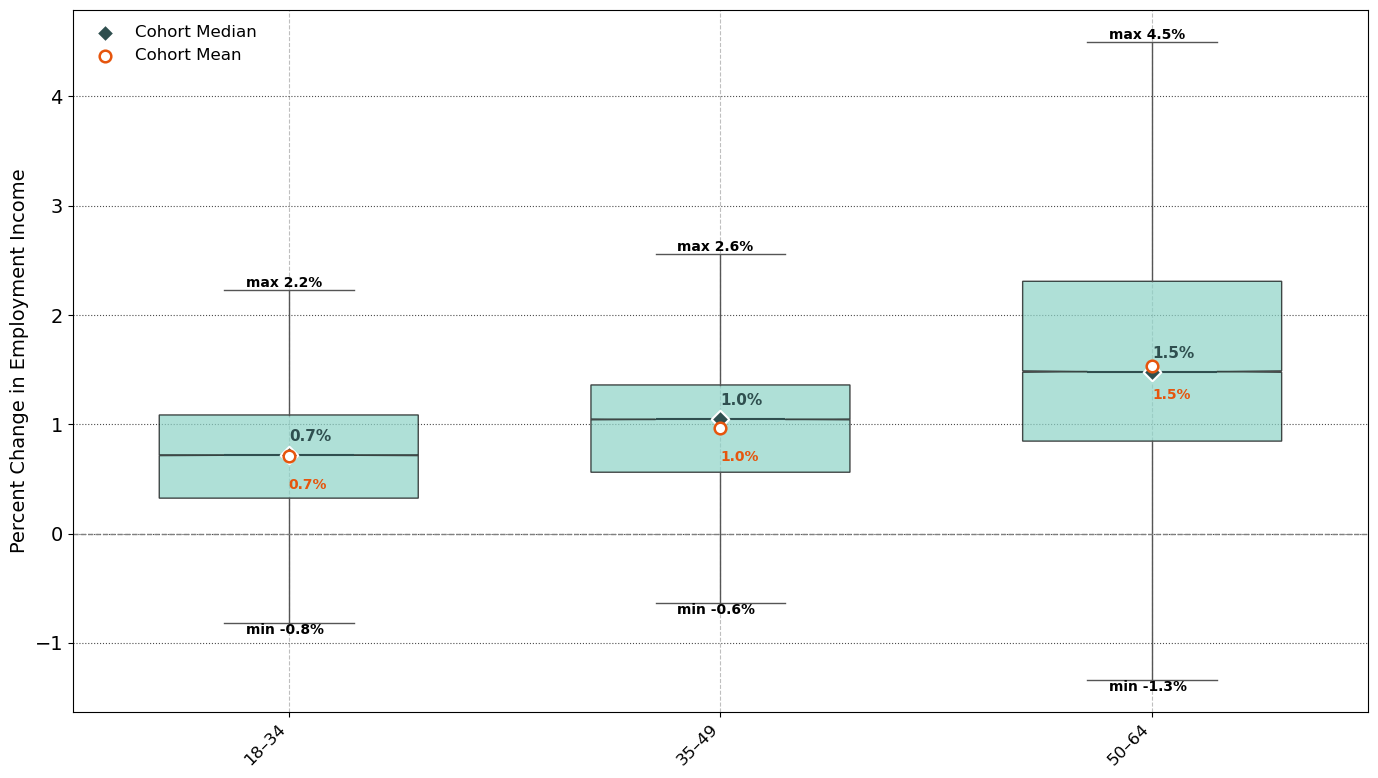

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# assume pct_work and age_labels are defined, and pct_work has at least 3 cohorts
data = pct_work[:3]
labels = age_labels[:3]
xpos = np.arange(len(labels))

# 1) Create a larger figure
fig, ax = plt.subplots(figsize=(14, 8))

# 2) Draw boxplot
bp = ax.boxplot(
    data,
    positions=xpos,
    widths=0.6,
    notch=True,
    showfliers=False,
    whis=1.5,
    patch_artist=True,
    medianprops=dict(color="#2f4f4f", linewidth=1.5),
    whiskerprops=dict(color="#555555", linewidth=1),
    capprops=dict(color="#555555", linewidth=1),
)
for box in bp['boxes']:
    box.set_facecolor('#8dd3c7')
    box.set_alpha(0.7)

# 3) Zero reference line
ax.axhline(0, linestyle='--', color='gray', linewidth=1)

# 4) Compute medians & whisker‐restricted means
meds = np.array([np.nanmedian(arr) for arr in data])
means = []
for i, arr in enumerate(data):
    lo = bp['caps'][2*i].get_ydata()[0]
    hi = bp['caps'][2*i+1].get_ydata()[0]
    in_range = arr[(arr >= lo) & (arr <= hi)]
    means.append(np.nanmean(in_range))
means = np.array(means)

# 5) Plot median & mean markers
ax.scatter(xpos, meds,
           marker='D', s=80,
           facecolors='#2f4f4f', edgecolors='white',
           linewidths=1.5, zorder=4,
           label='Cohort Median')
ax.scatter(xpos, means,
           marker='o', s=70,
           facecolors='white', edgecolors='#e6550d',
           linewidths=1.8, zorder=5,
           label='Cohort Mean')

# 6) Annotate min, max, median, mean to the right
offset_x = -0.1
for i, x in enumerate(xpos):
    lo   = bp['caps'][2*i].get_ydata()[0]
    hi   = bp['caps'][2*i+1].get_ydata()[0]
    med  = meds[i]
    mval = means[i]

    ax.text(x+offset_x, hi,
            f"max {hi:.1f}%",
            ha='left', va='bottom',
            fontsize=10, fontweight='bold')
    ax.text(x+offset_x, lo,
            f"min {lo:.1f}%",
            ha='left', va='top',
            fontsize=10, fontweight='bold')
    ax.text(x+offset_x+0.1, med +0.1,
            f"{med:.1f}%",
            ha='left', va='bottom',
            fontsize=11, fontweight='bold', color='#2f4f4f')
    ax.text(x+offset_x+0.1, mval-0.2,
            f"{mval:.1f}%",
            ha='left', va='top',
            fontsize=10, fontweight='bold', color='#e6550d')

# 7) Final styling
ax.set_xticks(xpos)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Percent Change in Employment Income', fontsize=14)
#ax.set_title('Work Income %Δ by Age Cohort', fontsize=16)
ax.grid(axis='y', linestyle=':', alpha=0.7)
ax.legend(frameon=False, fontsize=12, loc='upper left')

plt.tight_layout()
plt.savefig('employment_income_percent_change_large.png', dpi=300)
plt.show()


In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

# 3) Age bins
age_start  = 18
age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

# 4) Share the shocks between baseline and experiment
torch.manual_seed(1337)
N      = model_DL['Baseline'].sim.N
device = model_DL['Baseline'].sim.states.device
raw    = model_DL['Baseline'].draw_shocks(N).to(device)
model_DL['Baseline'].sim.shocks   = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()

# 5) Compute percent changes in cash‐on‐hand by age bin
pct_cash = []
for (a_lo, a_hi) in age_bins:
    t_lo  = a_lo - age_start
    t_hi  = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)

    # Baseline
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []
    sb = simulate_model(mb)
    WI_b = sb.states[..., 2].detach().cpu().numpy()

    # Experiment
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = [t_lo]
    se = simulate_model(me)
    WI_e = se.states[..., 2].detach().cpu().numpy()

    # Flatten from t_lo onward and drop zeros
    base = WI_b[t_lo:t_hi].ravel()
    exp  = WI_e[t_lo:t_hi].ravel()
    mask = base != 0
    pct_cash.append((exp[mask] - base[mask]) / base[mask] * 100)


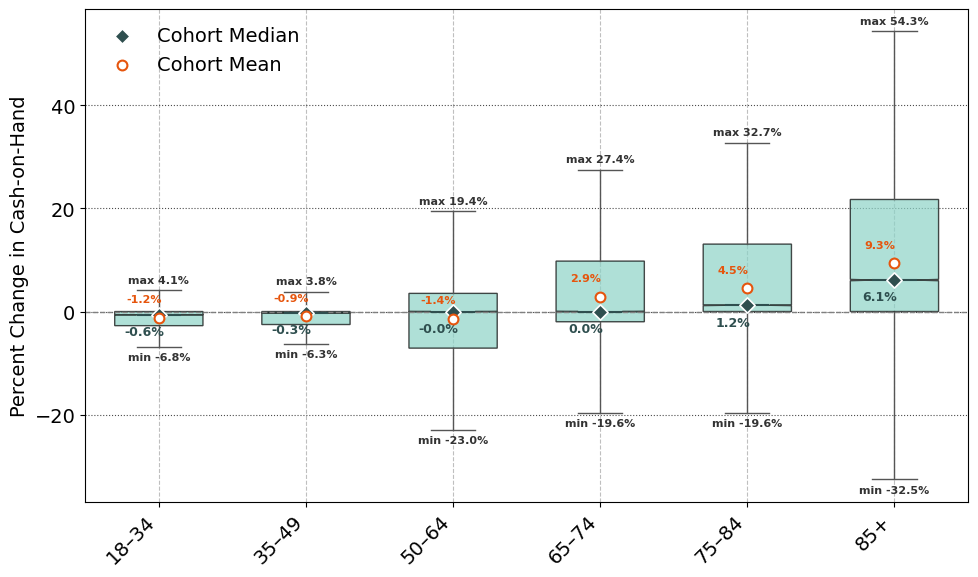

In [8]:
# 6) Plot
fig, ax = plt.subplots(figsize=(10, 6))
xpos = np.arange(len(age_labels))

# 6a) Boxplot
bp = ax.boxplot(
    pct_cash,
    positions=xpos,
    widths=0.6,
    notch=True,
    showfliers=False,
    whis=1.5,
    patch_artist=True,
    medianprops=dict(color="#2f4f4f", linewidth=1.5),
    whiskerprops=dict(color="#555555", linewidth=1),
    capprops=dict(color="#555555", linewidth=1),
)

# 6b) Colour boxes
for box in bp["boxes"]:
    box.set_facecolor("#8dd3c7")
    box.set_alpha(0.7)

# 6c) Zero line
ax.axhline(0, linestyle="--", color="gray", linewidth=1)

# 6d) Cohort medians & means
meds = np.array([np.nanmedian(arr) for arr in pct_cash])
means = []
for i, arr in enumerate(pct_cash):
    lo = bp["caps"][2*i].get_ydata()[0]
    hi = bp["caps"][2*i+1].get_ydata()[0]
    in_range = arr[(arr >= lo) & (arr <= hi)]
    means.append(np.nanmean(in_range))
means = np.array(means)

ax.scatter(
    xpos, meds,
    marker='D', s=60,
    facecolors='#2f4f4f', edgecolors='white',
    linewidths=1.2, zorder=4,
    label="Cohort Median"
)
ax.scatter(
    xpos, means,
    marker='o', s=50,
    facecolors='white', edgecolors='#e6550d',
    linewidths=1.5, zorder=5,
    label="Cohort Mean"
)

# 6e) Annotate medians & means (centred)
for i in range(len(age_labels)):
    ax.text(
        xpos[i]-0.1, meds[i] - 4.5,   # 1% above the median point
        f"{meds[i]:.1f}%",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold", color="#2f4f4f"
    )
    ax.text(
        xpos[i] -0.1, means[i] + 4.5,  # 1% below the mean point
        f"{means[i]:.1f}%",
        ha="center", va="top",
        fontsize=8, fontweight = "bold", color="#e6550d"
    )
    # annotate whisker caps
    lo = bp["caps"][2*i].get_ydata()[0]
    hi = bp["caps"][2*i+1].get_ydata()[0]
    ax.text(
        xpos[i], hi + 1.1,
        f"max {hi:.1f}%",
        ha="center", va="bottom",
        fontsize=8, fontweight = "bold", color="#333333"
    )
    ax.text(
        xpos[i], lo - 1.0,
        f"min {lo:.1f}%",
        ha="center", va="top",
        fontsize=8, fontweight = "bold", color="#333333"
    )

# 6f) Final formatting
ax.set_xticks(xpos)
ax.set_xticklabels(age_labels, rotation=45, ha="right")
ax.set_ylabel("Percent Change in Cash-on-Hand")
#ax.set_title("Cash-on-Hand Shock Impacts by Age Cohort")
ax.grid(axis='y', linestyle=':', linewidth=0.8, alpha=0.7)
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.savefig("mp_soft_cash_boxplot.png", dpi=300)
plt.show()

In [3]:
import numpy as np
import pandas as pd
import copy
import torch

# 2) Gini helper
def gini_coefficient(x: np.ndarray) -> float:
    """
    Compute Gini coefficient for non‐negative array x.
    Returns 0.0 if x is all zero or empty.
    """
    x = x.flatten()
    x = x[x >= 0]
    if x.size == 0 or x.sum() == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


# 3) compute helpers
def compute_net_wealth(S, O):
    return O[...,4] + O[...,3] - S[...,6] - O[...,5]

def compute_work_income(S, O, kappa):
    return kappa[:,None] * S[...,1] * O[...,1]

def compute_invest_income(S, O):
    return O[...,4] * (S[...,5]-1) + O[...,3] * (S[...,4]-1)

# 4) age bins
age_start  = 18
#age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
#age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]
age_bins   = [(18, 28), (29, 39), (40, 50), (51, 61), (62,72),(73,83)]
age_labels = ["18–28", "29–39", "40–50", "51–61", "62–72", "73-83"]

# 5) Pre-draw everything once
torch.manual_seed(1337)
N      = model_DL['Baseline'].sim.N
device = model_DL['Baseline'].sim.states.device
raw    = model_DL['Baseline'].draw_shocks(N).to(device)
model_DL['Baseline'].sim.shocks   = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()

# 6) Build rows
rows = []
for (a_lo, a_hi), label in zip(age_bins, age_labels):
    t_lo = a_lo - age_start
    t_hi  = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    sl   = slice(t_lo, t_hi)  # From t_lo to end of horizon

    # -- Baseline --
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []
    sb = simulate_model(mb)
    S_b = sb.states.detach().cpu().numpy()
    O_b = sb.outcomes.detach().cpu().numpy()
    k_b = mb.par.kappa.detach().cpu().numpy()

    # -- Experiment --
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = [t_lo]
    se = simulate_model(me)
    S_e = se.states.detach().cpu().numpy()
    O_e = se.outcomes.detach().cpu().numpy()
    k_e = me.par.kappa.detach().cpu().numpy()

    for model_key, (S,O,kappa) in [
        ("Baseline",(S_b,O_b,k_b)),
        ("Experiment",(S_e,O_e,k_e))
    ]:
        #cons = O[...,0][sl,:].ravel()
        nw   = compute_net_wealth(S,O)[sl,:].ravel()
        inc  = (compute_work_income(S,O,kappa) + compute_invest_income(S,O))[sl,:].ravel()


        rows.append({
            'Age bin': label,
            'Model':   model_key,
            #'Gini_consumption':  gini_coefficient(cons)*100,
            'Gini_net_wealth':   gini_coefficient(nw)*100,
            'Gini_total_income': gini_coefficient(inc)*100 #,
            #'Gini_cash_on_hand': gini_coefficient(cash)*100
        })

df = pd.DataFrame(rows).pivot(index='Age bin', columns='Model')
df


Gini_net_wealth            Gini_total_income           
Model          Baseline Experiment          Baseline Experiment
Age bin                                                        
18–34         52.170616  52.182747         31.240541  30.938974
35–49         54.786480  54.609020         10.017165  10.256417
50–64         54.756725  54.706501         13.855128  14.246300
65–74         48.071251  48.145752         33.757423  32.985210
75–84         42.797028  42.893661         20.609211  20.882725
85+           41.264107  41.403763         21.829346  22.677589

In [5]:
import pandas as pd

# assuming `df` is your pivoted DataFrame from before, with columns like
# ('Gini_consumption','Baseline'), ('Gini_consumption','Experiment'), etc.

# extract the baseline and experiment blocks
gini_base = df.xs('Baseline', axis=1, level=1)
gini_exp  = df.xs('Experiment', axis=1, level=1)

# compute percent change
gini_pct_change = (gini_exp - gini_base)  #/ gini_base * 100

# round to 3 decimals
gini_pct_change = gini_pct_change.round(3)

print(gini_pct_change)


         Gini_net_wealth  Gini_total_income
Age bin                                    
18–34              0.012             -0.302
35–49             -0.177              0.239
50–64             -0.050              0.391
65–74              0.075             -0.772
75–84              0.097              0.274
85+                0.140              0.848


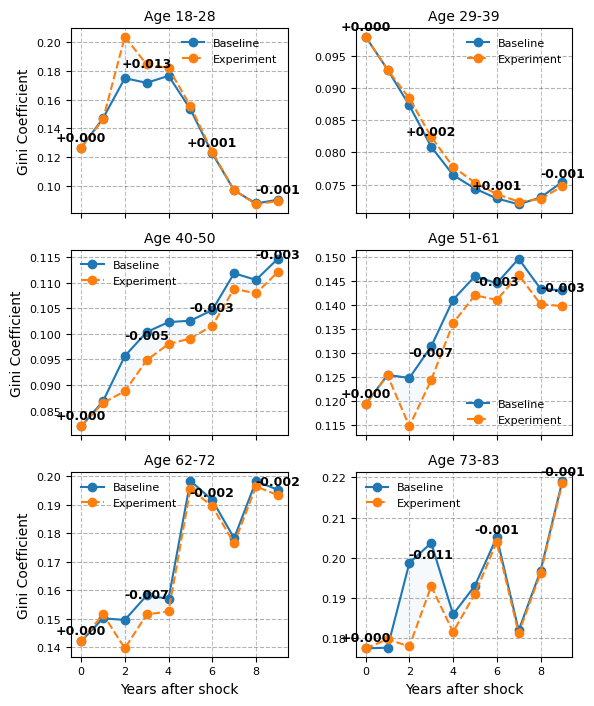

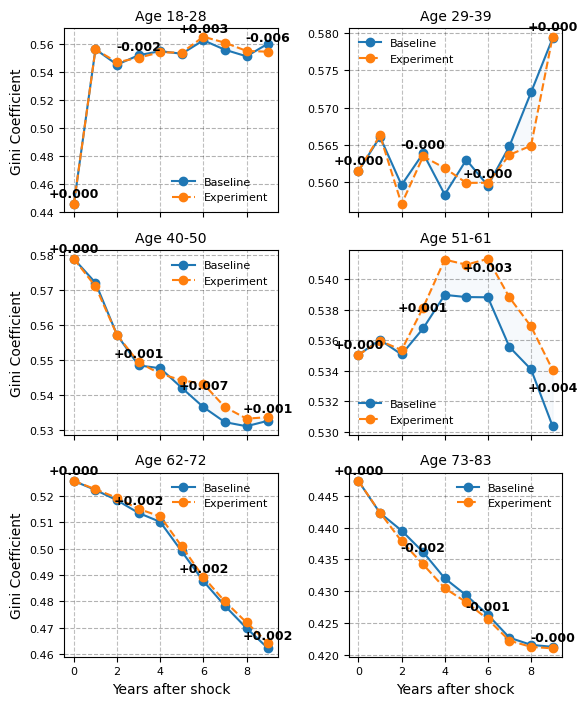

In [5]:
# ===============================================================
# 0) Imports & helpers  (keep if they aren't in the notebook yet)
# ===============================================================
import copy, numpy as np, matplotlib.pyplot as plt, torch

def gini_coefficient(x: np.ndarray) -> float:
    x = x[x >= 0].flatten()
    if x.size == 0 or x.sum() == 0:
        return 0.0
    x = np.sort(x)
    n   = x.size
    cum = np.cumsum(x)
    return (n + 1 - 2 * cum.sum() / cum[-1]) / n

def gini_series(mat: np.ndarray) -> np.ndarray:
    return np.array([gini_coefficient(row) for row in mat])

def net_wealth(S, O):
    return O[...,4] + O[...,3] - S[...,6] - O[...,5]

def work_income(S, O, κ):
    return κ[:, None] * S[...,1] * O[...,1]

def invest_income(S, O):
    return O[...,4]*(S[...,5]-1) + O[...,3]*(S[...,4]-1)

# ---------------------------------------------------------------
# 1) Age-bins & LaTeX sizing constants
# ---------------------------------------------------------------
age_start  = 18
age_bins   = [(18,28),(29,39),(40,50),(51,61),(62,72),(73,83)]
age_labels = ["18-28","29-39","40-50","51-61","62-72","73-83"]
n_bins     = len(age_bins)

TEXTWIDTH_PT = 430        # adjust if \textwidth differs
IN_PER_PT    = 1 / 72.27
FIG_W        = TEXTWIDTH_PT * IN_PER_PT       # full text width
FIG_H        = FIG_W * 1.2                    # aspect ratio for 3×2 grid

# ---------------------------------------------------------------
# 2) Draw identical idio-shocks for comparability
# ---------------------------------------------------------------
torch.manual_seed(1337)
N    = model_DL['Baseline'].sim.N
raw  = model_DL['Baseline'].draw_shocks(N).to(model_DL['Baseline'].sim.states.device)
model_DL['Baseline'  ].sim.shocks = raw.clone()
model_DL['Experiment'].sim.shocks = raw.clone()

# ---------------------------------------------------------------
# 3) Build baseline & experiment Gini arrays
# ---------------------------------------------------------------
gB_nw, gE_nw   = [], []
gB_inc,gE_inc  = [], []

for (a_lo, a_hi) in age_bins:
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    sl   = slice(t_lo, t_hi)

    # ---------- simulate baseline ----------
    mb = copy.deepcopy(model_DL['Baseline'])
    mb.par.shock_periods = []
    with torch.no_grad():
        sb = simulate_model(mb)
    S_b = sb.states.detach().cpu().numpy()
    O_b = sb.outcomes.detach().cpu().numpy()
    κ_b = mb.par.kappa.detach().cpu().numpy()

    # ---------- simulate experiment ----------
    me = copy.deepcopy(model_DL['Experiment'])
    me.par.shock_periods = [t_lo]
    with torch.no_grad():
        se = simulate_model(me)
    S_e = se.states.detach().cpu().numpy()
    O_e = se.outcomes.detach().cpu().numpy()
    κ_e = me.par.kappa.detach().cpu().numpy()

    # ---------- levels & Gini ----------
    NW_b, NW_e = net_wealth(S_b,O_b)[sl],   net_wealth(S_e,O_e)[sl]
    TI_b = work_income(S_b,O_b,κ_b) + invest_income(S_b,O_b)
    TI_e = work_income(S_e,O_e,κ_e) + invest_income(S_e,O_e)
    TI_b, TI_e = TI_b[sl], TI_e[sl]

    gB_nw.append(  gini_series(NW_b))
    gE_nw.append(  gini_series(NW_e))
    gB_inc.append( gini_series(TI_b))
    gE_inc.append( gini_series(TI_e))

# ---------------------------------------------------------------
# 4) Pad ragged → [bins × T_max] cubes
# ---------------------------------------------------------------
def pad_cube(ragged):
    T_max = max(r.size for r in ragged)
    cube  = np.full((n_bins, T_max), np.nan)
    for i, r in enumerate(ragged):
        cube[i, :r.size] = r
    return cube

B_nw, E_nw   = pad_cube(gB_nw),  pad_cube(gE_nw)
B_inc,E_inc  = pad_cube(gB_inc), pad_cube(gE_inc)
T_max        = B_nw.shape[1]

# ---------------------------------------------------------------
# 5) Plot helper (baseline vs exp + shaded Δ + annotations)
# ---------------------------------------------------------------
def plot_gini_BE(cB, cE, file_stem,
                 label_step=3, fmt="{:+.3f}", ylab="Gini Coefficient"):

    # --- font sizes tuned for LaTeX scaling ---
    plt.rcParams.update({
        "font.size":        9,
        "axes.titlesize":  10,
        "axes.labelsize":  10,
        "legend.fontsize":  8,
        "xtick.labelsize":  8,
        "ytick.labelsize":  8,
    })

    fig, axes = plt.subplots(3, 2, figsize=(FIG_W, FIG_H), sharex=True)
    axes = axes.ravel()

    for idx in range(n_bins):
        yrs = np.where(~np.isnan(cB[idx]))[0]
        gB  = cB[idx, yrs];  gE = cE[idx, yrs];  dG = gE - gB
        ax  = axes[idx]

        ax.fill_between(yrs, gB, gE, alpha=.15, color="#c5d8f0")
        ax.plot(yrs, gB, "-o",  label="Baseline")
        ax.plot(yrs, gE, "--o", label="Experiment")

        # numeric ΔGini annotations
        for y, dg in zip(yrs, dG):
            if (y % label_step == 0) or (y == yrs[-1]):
                ax.annotate(fmt.format(dg),
                            xy=(y, (gB[y] + gE[y]) / 2),
                            xytext=(0, 5), textcoords="offset points",
                            ha="center", fontsize=9, fontweight="bold")

        ax.set_title(f"Age {age_labels[idx]}")
        ax.grid(True, axis="y", alpha=.3)
        ax.legend(frameon=False)

        # y-axis label only on left panels
        if idx % 2 == 0:
            ax.set_ylabel(ylab)

    for ax in axes[4:]:
        ax.set_xlabel("Years after shock")

    plt.tight_layout()
    #plt.savefig(f"{file_stem}.pdf",  bbox_inches="tight")  # vector
    #plt.savefig(f"{file_stem}.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------------------------------------------------------
# 6) Produce full-width figures
# ---------------------------------------------------------------
plot_gini_BE(B_inc, E_inc, "total_income_gini_full")
plot_gini_BE(B_nw,  E_nw,  "net_wealth_gini_full")
